In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyod.models.knn import KNN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from dateutil.relativedelta import relativedelta
import warnings, datetime
warnings.filterwarnings("ignore")

### Load Data

In [2]:
df = pd.read_csv("models/origin_data.csv")
df["week"] = pd.to_datetime(df["week"])
df = df.set_index(["week"])
print(df.shape)
df.head()

(200, 5)


,GIGE,USB2.0,USB3.0,Unknown,other
week,,,,,
2018-12-31,NaN,NaN,59.0,15705.0,NaN
2019-01-07,1950.0,300.0,372.0,107134.0,247.0
2019-01-14,1598.0,62000.0,840.0,94997.0,143887.0
2019-01-21,701.0,98700.0,27303.0,530507.0,128316.0
2019-01-28,353.0,630.0,4110.0,919.0,4878.0


### Missing Value

In [3]:
# 無銷售量資料代表該週無交易 = 0
df = df.fillna(0)

### outlier & expotential

In [4]:
df_outlier = pd.DataFrame(index = df.index)
for col, value in df.items():
    clf = KNN()
    clf.fit(df[[col]])  # df维度是 [n_samples, n_features]，必须是数值型，不能包含缺失值

    outlier = clf.labels_  # (0表示正常值，1表示异常值)
    max_ = df[col].iloc[~outlier.astype(bool)].max()
    min_ = df[col].iloc[~outlier.astype(bool)].min()

    value = [max_ if i > max_ else i for i in value]
    value = [min_ if i < min_ else i for i in value]

    df_outlier[col] = value

### 每四週累加，單位週->月

In [5]:
df_cum = df_outlier.rolling(4).sum()
df_cum = df_cum.dropna()
df_cum

,GIGE,USB2.0,USB3.0,Unknown,other
week,,,,,
2019-01-21,3899.0,161000.0,14669.0,748343.0,272450.0
2019-01-28,4252.0,161630.0,18720.0,733557.0,277328.0
2019-02-04,2652.0,161330.0,18348.0,626423.0,277081.0
2019-02-11,1070.0,99330.0,17670.0,569726.0,133209.0
2019-02-18,449.0,645.0,6402.0,77199.0,13177.0
...,...,...,...,...,...
2022-09-26,2000.0,395350.0,15335.0,0.0,0.0
2022-10-03,2038.0,311350.0,15355.0,0.0,0.0
2022-10-10,2288.0,300950.0,15315.0,0.0,0.0


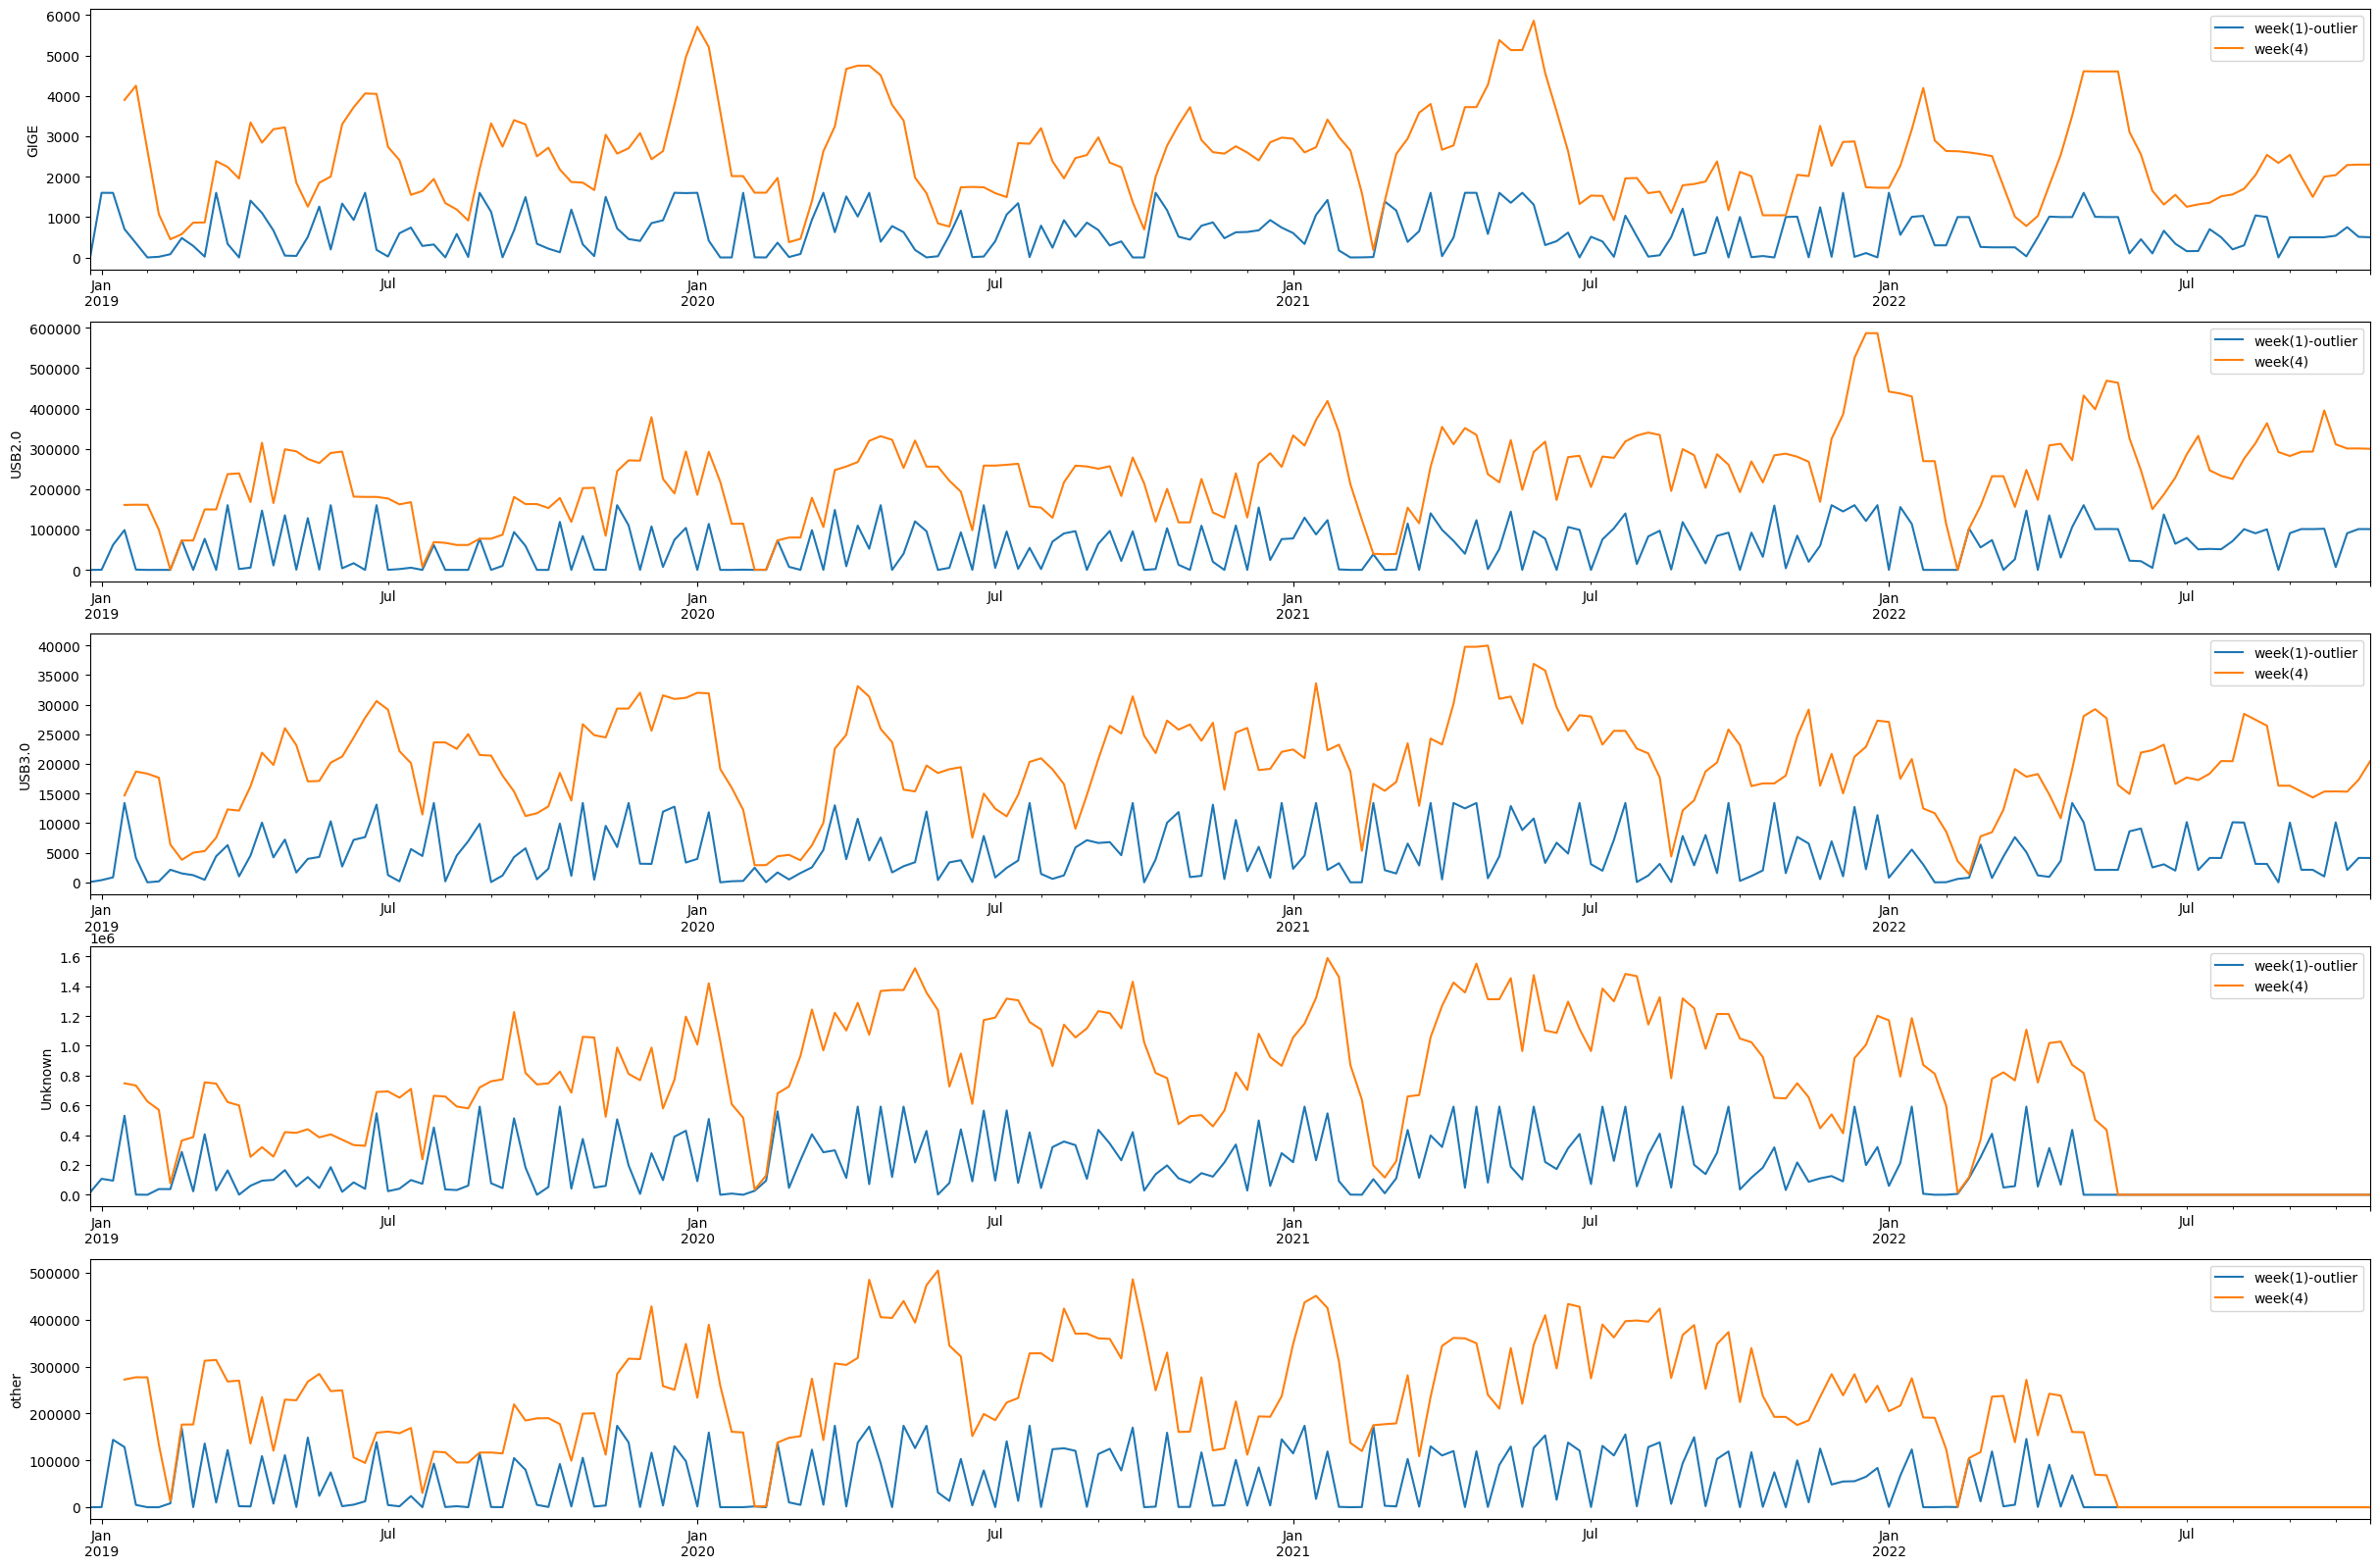

In [6]:
fig, ax = plt.subplots(5, 1, figsize = (30, 20))
for i, col in enumerate(df.columns):
    # df[col].plot(ax = ax[i], label = "week(1)")
    df_outlier[col].plot(ax = ax[i], label = "week(1)-outlier")
    df_cum[col].plot(ax = ax[i], label = "week(4)")

    ax[i].legend()
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(col)

### 選擇要預測的商品

In [7]:
df.columns

Index(['GIGE', 'USB2.0', 'USB3.0', 'Unknown', 'other'], dtype='object')

In [8]:
col = "Unknown"
series = df_cum[[col]].copy()
series.columns = ["qty"]
series.head()

,qty
week,
2019-01-21,748343.0
2019-01-28,733557.0
2019-02-04,626423.0
2019-02-11,569726.0
2019-02-18,77199.0


### 切分 (連續變數轉分類預測)

In [9]:
# 最小值和最大值的十進位數
digit1 = len(str(int(series["qty"].max()))) + 1
digit2 = len(str(int(series["qty"].min()))) - 1
digit1, digit2

(8, 0)

In [10]:
# 產生區間
bins = []
for i in range(digit2, digit1):
    if i >= 4: # 超過10000，每一個進位區間中多切四份，避免區間過大
        bins1 = np.linspace(10**i, 10**(i+1), 5)
        if i > 4:
            bins1 = np.delete(bins1, 0) # 刪除重複的數字
        bins.extend(bins1)
    else:
        bins.append(10**i)
        
bins[0] = bins[0] - 2
bins

[-1,
 10,
 100,
 1000,
 10000.0,
 32500.0,
 55000.0,
 77500.0,
 100000.0,
 325000.0,
 550000.0,
 775000.0,
 1000000.0,
 3250000.0,
 5500000.0,
 7750000.0,
 10000000.0,
 32500000.0,
 55000000.0,
 77500000.0,
 100000000.0]

In [11]:
# 切割
series["cut"] = pd.cut(series["qty"], bins) # 方便之後看label的區間是多少
series["label"] = pd.cut(series["qty"], bins, labels = list(range(len(bins)-1))).astype(int)
series.head()

,qty,cut,label
week,,,
2019-01-21,748343.0,"(550000.0, 775000.0]",10
2019-01-28,733557.0,"(550000.0, 775000.0]",10
2019-02-04,626423.0,"(550000.0, 775000.0]",10
2019-02-11,569726.0,"(550000.0, 775000.0]",10
2019-02-18,77199.0,"(55000.0, 77500.0]",6


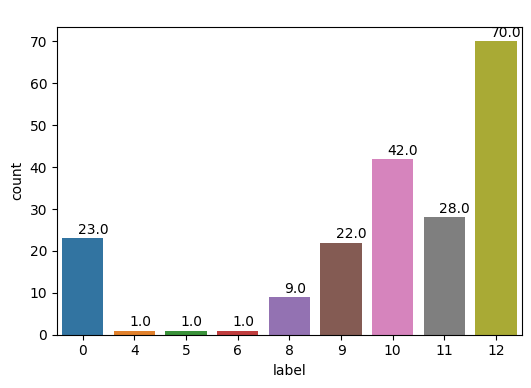

In [12]:
# 各列別數量
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x = "label", data = series)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 1))
plt.show()

In [13]:
# 各類別對應的區間
cat = series[["cut", "label"]].drop_duplicates().sort_values("label")
cat = cat.set_index("label")
cat

,cut
label,
0,"(-1.0, 10.0]"
4,"(10000.0, 32500.0]"
5,"(32500.0, 55000.0]"
6,"(55000.0, 77500.0]"
8,"(100000.0, 325000.0]"
9,"(325000.0, 550000.0]"
10,"(550000.0, 775000.0]"
11,"(775000.0, 1000000.0]"
12,"(1000000.0, 3250000.0]"


In [14]:
series = series.drop(["cut"], axis = 1)
series

,qty,label
week,,
2019-01-21,748343.0,10
2019-01-28,733557.0,10
2019-02-04,626423.0,10
2019-02-11,569726.0,10
2019-02-18,77199.0,6
...,...,...
2022-09-26,0.0,0
2022-10-03,0.0,0
2022-10-10,0.0,0


### 特徵生成

In [15]:
df1 = series.drop(["qty"], axis = 1)

In [16]:
# 滯後特徵
for i in range(4, 13):
    df1[f"label_lag_{i}"] = df1["label"].shift(i)

# 時間特徵
df1["year"] = df1.index.year
df1["month"] = df1.index.month
df1["quarter"] = df1.index.quarter
df1["week"] = df1.index.week

df2 = df1.dropna()
df2 = df2.reset_index(drop = True)
df2.head()

,label,label_lag_4,label_lag_5,label_lag_6,label_lag_7,label_lag_8,label_lag_9,label_lag_10,label_lag_11,label_lag_12,year,month,quarter,week
0,8,10.0,10.0,9.0,9.0,6.0,10.0,10.0,10.0,10.0,2019,4,2,16
1,8,10.0,10.0,10.0,9.0,9.0,6.0,10.0,10.0,10.0,2019,4,2,17
2,9,10.0,10.0,10.0,10.0,9.0,9.0,6.0,10.0,10.0,2019,4,2,18
3,9,8.0,10.0,10.0,10.0,10.0,9.0,9.0,6.0,10.0,2019,5,2,19
4,9,8.0,8.0,10.0,10.0,10.0,10.0,9.0,9.0,6.0,2019,5,2,20


### Label encoding

In [17]:
#對年做排序
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df2['year'] = ord_enc.fit_transform(df2[['year']]).astype(int)
df2.head(3)

,label,label_lag_4,label_lag_5,label_lag_6,label_lag_7,label_lag_8,label_lag_9,label_lag_10,label_lag_11,label_lag_12,year,month,quarter,week
0,8,10.0,10.0,9.0,9.0,6.0,10.0,10.0,10.0,10.0,0,4,2,16
1,8,10.0,10.0,10.0,9.0,9.0,6.0,10.0,10.0,10.0,0,4,2,17
2,9,10.0,10.0,10.0,10.0,9.0,9.0,6.0,10.0,10.0,0,4,2,18


### Heat map

In [18]:
corr = df2.corr().sort_values("label", ascending = False)
corr = corr.iloc[:10]
corr = corr[corr.index]

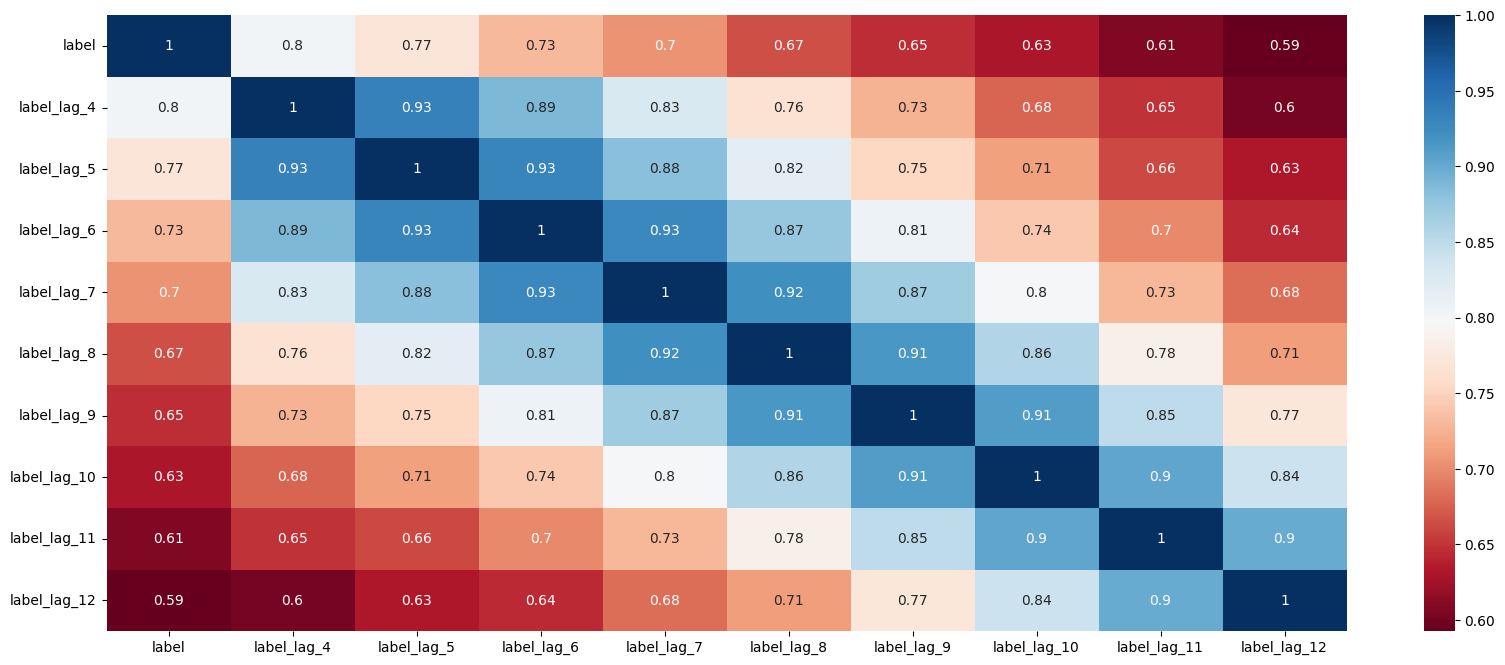

In [19]:
plt.figure(figsize=(20, 8))
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

### Train test split

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2.drop(["label"], axis = 1), df2[["label"]], test_size=0.2, shuffle = False)#, "qty", "cut"
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(148, 13) (37, 13) (148, 1) (37, 1)


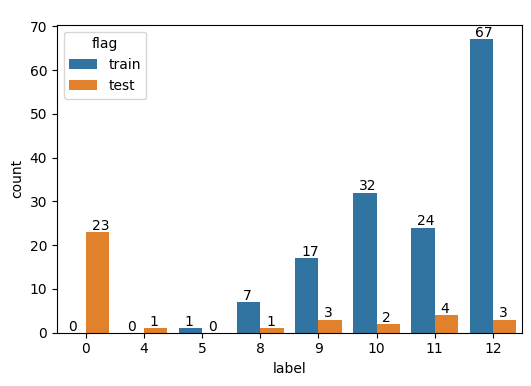

In [21]:
df3 = df2.copy()
df3.loc[:len(X_train), "flag"] = "train"
df3.loc[len(X_train):, "flag"] = "test"

fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x = "label", hue = "flag", data = df3)

for p in ax.patches:
    if np.isnan(p.get_height()):
        continue
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.1, p.get_height() + 0.5), color='black', size=10)
plt.show()

### Resample

In [22]:
# 刪除數量少於2的類別
counts = y_train["label"].value_counts() 
drop_label = counts[counts < 2].index.to_list()

y_train = y_train.query("label not in @drop_label")
X_train = X_train.loc[y_train.index]

drop_label

[5]

In [23]:
# 刪除test有， train沒有的data
train_label = y_train["label"].unique()
y_test = y_test.query("label in @train_label")
X_test = X_test.loc[y_test.index]
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (147, 13), X_test: (13, 13), y_train: (147, 1), y_test: (13, 1)


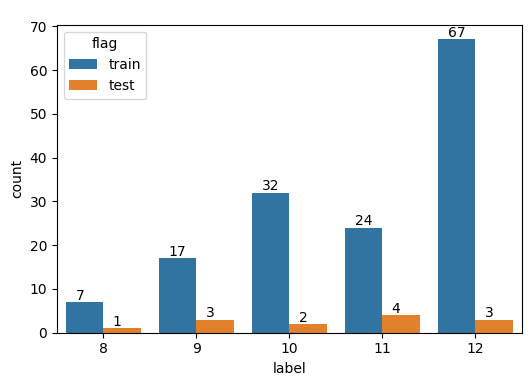

In [24]:
y_train1, y_test1 = y_train.copy(), y_test.copy()
y_train1["flag"] = "train"
y_test1["flag"] = "test"
y = pd.concat([y_train1, y_test1])


fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x = "label", hue = "flag", data = y)

for p in ax.patches:
    if np.isnan(p.get_height()):
        continue
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.1, p.get_height() + 0.5), color='black', size=10)
plt.show()

In [25]:
# 檢查類型中最少的數量是否比ADASYN模型所默認的參數還小
if drop_label != []:
    counts = counts.drop(drop_label)
    n_neighbors = min(counts.min()-1, 5)
else:
    n_neighbors = counts.min()-1

In [26]:
# resample

oversample = SMOTE(random_state=99, k_neighbors = n_neighbors)
# oversample = ADASYN(random_state=99, n_neighbors = n_neighbors)
X_train, y_train = oversample.fit_resample(X_train, y_train)

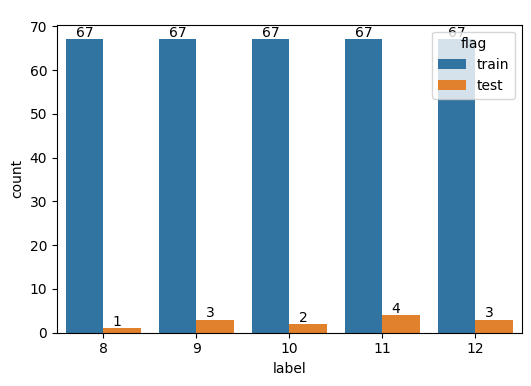

In [27]:
y_train1, y_test1 = y_train.copy(), y_test.copy()
y_train1["flag"] = "train"
y_test1["flag"] = "test"
y = pd.concat([y_train1, y_test1])


fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x = "label", hue = "flag", data = y)

for p in ax.patches:
    if np.isnan(p.get_height()):
        continue
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.1, p.get_height() + 0.5), color='black', size=10)
plt.show()

### Skew

In [28]:
from scipy.stats import skew

skewness = X_train.select_dtypes(float).apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skewness

,Feature,Skew
0,label_lag_8,-0.829643
1,label_lag_10,-0.865181
2,label_lag_12,-0.988989


In [29]:
from sklearn.preprocessing import PowerTransformer
if len(skewness != 0):
    X_pt = PowerTransformer(method = 'yeo-johnson')
    X_train[skewness["Feature"]] = X_pt.fit_transform(X_train[skewness["Feature"]])
    X_test[skewness["Feature"]] = X_pt.transform(X_test[skewness["Feature"]])

### Scaling

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_scaler = MinMaxScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns = X_scaler.feature_names_in_)
X_test = pd.DataFrame(X_scaler.transform(X_test), columns = X_scaler.feature_names_in_)

### Train

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier


random_state = 99#None
models = {
    "Logistic": LogisticRegression(),
    "Bayes (Gaussian)": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(probability = True),
    "Neural Network": MLPClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = random_state),
    "Random Forest": RandomForestClassifier(random_state = random_state, class_weight="balanced"),
    "Gradient Boost": GradientBoostingClassifier(),
    # "XGBoost": XGBClassifier(random_state = random_state),
    "LightGBM": LGBMClassifier(random_state = random_state), # feature name should be number
    # "Cat Boost": CatBoostClassifier(random_state = random_state),
    "Bayes (Complement)": ComplementNB(), # for imbalance data (X cannot be negative)
    # "Easy Ensemble (AdaBoost)":EasyEnsembleClassifier(random_state = random_state),
    # "Easy Ensemble (Logistic)":EasyEnsembleClassifier(random_state = random_state, base_estimator = LogisticRegression()),
    # "Easy Ensemble (SVC)":EasyEnsembleClassifier(random_state = random_state, base_estimator = SVC(probability = True)),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

Logistic trained.
Bayes (Gaussian) trained.
KNN trained.
SVC trained.
Neural Network trained.
Decision Tree trained.
Random Forest trained.
Gradient Boost trained.
LightGBM trained.
Bayes (Complement) trained.


### Evaluate models

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

acc_bound = 0.7
f1w_bound = 0.5

score = []
flag = 1
cv_flag = 0
for key, model in models.items():
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)

    acc_train  = accuracy_score(y_train, pred_train).round(2)
    acc_test   = accuracy_score(y_test, pred_test).round(2)

    recall_train  = recall_score(y_train, pred_train, average = 'weighted').round(2)
    recall_test   = recall_score(y_test, pred_test, average = 'weighted').round(2)

    precision_train  = precision_score(y_train, pred_train, average = 'weighted').round(2)
    precision_test   = precision_score(y_test, pred_test, average = 'weighted').round(2)

    f1_train = f1_score(y_train, pred_train, average = 'weighted').round(2)
    f1_test = f1_score(y_test, pred_test, average = 'weighted').round(2)
    f1_macro = f1_score(y_test, pred_test, average = 'macro').round(2)
    
    if flag == 1:
        col1 = [acc_train, acc_test, recall_train, recall_test, precision_train, precision_test, f1_train, f1_test, f1_macro]
        col2 = ["Accuracy_train", "Accuracy_test", "Recall_train", "Recall_test", "Precision_train", "Precision_test", "f1_train", "f1_test", "f1_test_macro"]
    else:
        col1 = [acc_test, recall_test, precision_test, f1_test]
        col2 = ["Accuracy", "Recall", "Precision", "f1"]

    if cv_flag:
        # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
        cv_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
        cv_score = cv_scores.mean().round(2)
        col1 += [cv_score]
        col2 += ["f1_cv"]

    score.append(col1)
    
    if (acc_test >= acc_bound) & (f1_test >= f1w_bound):
        col3 = sorted(list(set(y_test["label"]) | set(pred_test)))
        confusion = pd.DataFrame(confusion_matrix(y_test, pred_test), index = col3, columns = col3)
        confusion["Total"] = confusion.sum(axis = 1)
        confusion.loc["Total"] = confusion.sum(axis = 0)

        
        confusion = confusion.astype(int)
        
        print(f"<< {key.lstrip()} >>")
        print(f"\nConfusion Matrix:\n {confusion}")
        print(f"\nClassification Report:\n{classification_report(y_test, pred_test)}")
        print("-"*60)
    
index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score.query("(Accuracy_test >= @acc_bound) & (f1_test >= @f1w_bound)")

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,f1_train,f1_test,f1_test_macro


In [33]:
score.sort_values(["Accuracy_test", "f1_test_macro", "f1_test"], ascending = False)

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,f1_train,f1_test,f1_test_macro
LightGBM,1.00,0.31,1.00,0.31,1.00,0.15,1.00,0.18,0.29
Gradient Boost,1.00,0.31,1.00,0.31,1.00,0.26,1.00,0.25,0.28
KNN,0.83,0.31,0.83,0.31,0.84,0.12,0.83,0.17,0.23
Random Forest,1.00,0.31,1.00,0.31,1.00,0.11,1.00,0.16,0.23
Neural Network,0.68,0.31,0.68,0.31,0.69,0.22,0.67,0.20,0.15
SVC,0.79,0.23,0.79,0.23,0.80,0.08,0.79,0.12,0.10
Logistic,0.55,0.23,0.55,0.23,0.54,0.06,0.54,0.09,0.08
Bayes (Complement),0.44,0.23,0.44,0.23,0.44,0.06,0.36,0.09,0.08
Decision Tree,1.00,0.15,1.00,0.15,1.00,0.08,1.00,0.10,0.18
Bayes (Gaussian),0.55,0.15,0.55,0.15,0.58,0.13,0.55,0.13,0.16


In [34]:
score1 = score.sort_values(["Accuracy_test", "f1_test_macro", "f1_test"], ascending = False)
best_model_name = score1.index[0]
best_model_name

'LightGBM'

### Predict

In [35]:
start = "2022-02-03"
end = "2023-05-10"

In [36]:
best_model = models[best_model_name]

In [37]:
# 預測區間
start = datetime.datetime(int(start[:4]), 1, 1)

end = datetime.datetime(int(end[:4]), 12, 31)

start_pred = series.index[-1]

In [38]:
# 各類別的統計資料
medain = series.groupby("label")["qty"].median()
std = series.groupby("label")["qty"].std()
mean = series.groupby("label")["qty"].mean()

print(medain)
print(std)

label
0           0.0
4       12762.0
5       34713.0
6       77199.0
8      225483.0
9      428239.0
10     683043.0
11     868426.0
12    1216433.5
Name: qty, dtype: float64
label
0          0.000000
4               NaN
5               NaN
6               NaN
8      71522.093034
9      66506.373873
10     64827.477654
11     70940.545665
12    152188.801490
Name: qty, dtype: float64


In [39]:
# 抓出歷史的相關資料
series["start"] = None
series["end"] = None
series["median"] = None
series["random"] = None
series["pred"] = None

for i in range(len(series)):
    pred = series.iloc[i, 1]
    series.iloc[i, 2] = cat.loc[pred]['cut'].left
    series.iloc[i, 3] = cat.loc[pred]['cut'].right
    series.iloc[i, 4] = medain[pred]

    if np.isnan(std[pred]) or (std[pred] == 0):
        series.iloc[i, 5] = np.random.randint(5, 10)
    else:
        series.iloc[i, 5] = round(np.random.normal(scale = std[pred]*0.5))

    series.iloc[i, 6] = series.iloc[i, 4] + series.iloc[i, 5]
    if (series.iloc[i, 6] < series.iloc[i, 2]):
        series.iloc[i, 6] = series.iloc[i, 2]
    elif (series.iloc[i, 6] > series.iloc[i, 3]):
        series.iloc[i, 6] = series.iloc[i, 3]
series.head()

,qty,label,start,end,median,random,pred
week,,,,,,,
2019-01-21,748343.0,10,550000.0,775000.0,683043.0,-8257,674786.0
2019-01-28,733557.0,10,550000.0,775000.0,683043.0,-37645,645398.0
2019-02-04,626423.0,10,550000.0,775000.0,683043.0,-9546,673497.0
2019-02-11,569726.0,10,550000.0,775000.0,683043.0,-26577,656466.0
2019-02-18,77199.0,6,55000.0,77500.0,77199.0,5,77204.0


<AxesSubplot: xlabel='week'>

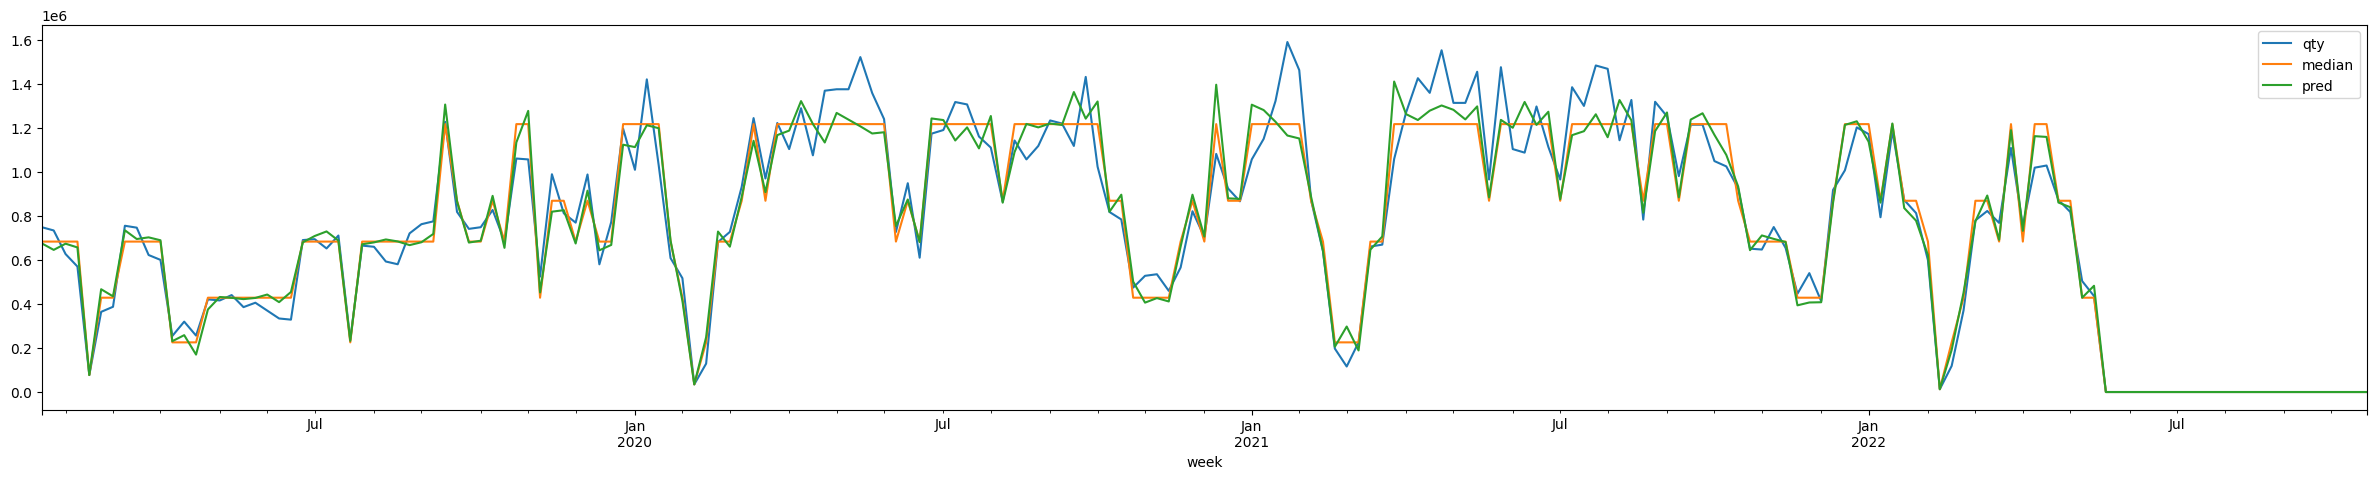

In [40]:
series[["qty", "median", "pred"]].plot(figsize = (30, 5))

In [41]:
# 預測未來一年的資料
pred_date = start_pred + relativedelta(weeks = 1)
while pred_date < end:
    # 建立預測日期
    series.loc[pred_date] = None
    df1 = series.copy()


    #特徵生成
    ## 滯後特徵
    for i in range(4, 13):
        df1[f"label_lag_{i}"] = df1["label"].shift(i)

    ## 時間特徵
    df1["year"] = df1.index.year
    df1["month"] = df1.index.month
    df1["quarter"] = df1.index.quarter
    df1["week"] = df1.index.week


    # 特徵工程

    ## label-encoding
    df1[["year"]] = ord_enc.fit_transform(df1[["year"]])

    pred_X = df1.iloc[-1:, -13:]

    ## skew
    if len(skewness != 0):
        pred_X[skewness["Feature"]] = X_pt.transform(pred_X[skewness["Feature"]])
    ## scaling
    pred_X = pd.DataFrame(X_scaler.transform(pred_X), columns = X_scaler.feature_names_in_)


    # predict
    pred = best_model.predict(pred_X)


    # save predict
    series.iloc[-1, 1] = pred[0]
    series.iloc[-1, 2] = cat.loc[pred[0]]['cut'].left
    series.iloc[-1, 3] = cat.loc[pred[0]]['cut'].right
    series.iloc[-1, 4] = medain[pred[0]]

    if np.isnan(std[pred[0]]) or (std[pred[0]] == 0):
        series.iloc[-1, 5] = np.random.randint(5, 10)
    else:
        series.iloc[-1, 5] = round(np.random.normal(scale = std[pred[0]]*0.5))
    
    series.iloc[-1, 6] = series.iloc[-1, 4] + series.iloc[-1, 5]
    if (series.iloc[-1, 6] < series.iloc[-1, 2]):
        series.iloc[-1, 6] = series.iloc[-1, 2]
    elif (series.iloc[-1, 6] > series.iloc[-1, 3]):
        series.iloc[-1, 6] = series.iloc[-1, 3]

    
    pred_date = series.index[-1] + relativedelta(weeks = 1)
series.tail()

,qty,label,start,end,median,random,pred
week,,,,,,,
2023-11-27,NaN,9.0,325000.0,550000.0,428239.0,42981,471220.0
2023-12-04,NaN,9.0,325000.0,550000.0,428239.0,-47785,380454.0
2023-12-11,NaN,11.0,775000.0,1000000.0,868426.0,-15655,852771.0
2023-12-18,NaN,12.0,1000000.0,3250000.0,1216433.5,12447,1228880.5
2023-12-25,NaN,12.0,1000000.0,3250000.0,1216433.5,-44025,1172408.5


In [42]:
# 抓出每個月最後一周 (最後一周往前推四週的累積)
series["year"] = series.index.year
series["month"] = series.index.month
series_keep = series[["year", "month"]].drop_duplicates(keep = "last")
series = series.loc[series_keep.index]

In [43]:
# 抓出預測區間內的資料
series1 = series[(series.index >= start) & (series.index <= end)]
series1 = series1.drop(["year", "month"], axis = 1)
series1.iloc[:, 1:] = series1.iloc[:, 1:].astype(int)
series1.head()

,qty,label,start,end,median,random,pred
week,,,,,,,
2022-01-31,812475.0,11,775000,1000000,868426,-90543,777883
2022-02-28,370186.0,9,325000,550000,428239,22724,450963
2022-03-28,1108042.0,12,1000000,3250000,1216433,-27546,1188887
2022-04-25,872533.0,11,775000,1000000,868426,-8020,860406
2022-05-30,0.0,0,-1,10,0,5,5


<AxesSubplot: xlabel='week'>

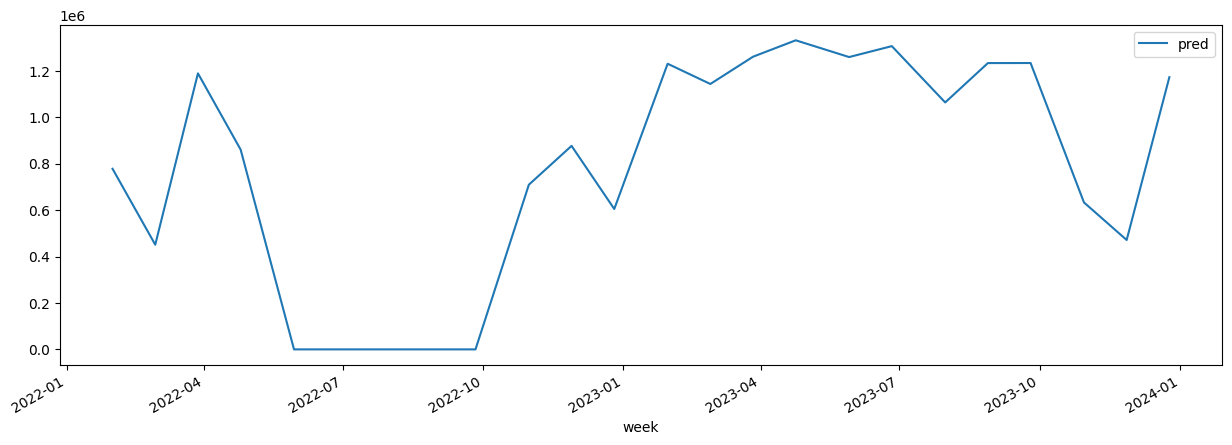

In [44]:
series1[["pred"]].plot(figsize = (15, 5))

In [45]:
results = {i: pd.DataFrame() for i in range(start.year, end.year+1)}

In [46]:
series2 = series1[["pred"]]
series2["year"] = series2.index.year
g = series2.groupby("year")
for year in g.size().index:
    result = g.get_group(year)
    result = result.drop("year", axis = 1)
    result.columns = [col]
    result = result.T
    result = result.reset_index()
    result.columns = ["series"] + [f"{i}m" for i in range(1, 13)]
    results[year] = pd.concat([results[year], result])
result

,series,1m,2m,3m,4m,5m,6m,7m,8m,9m,10m,11m,12m
0,Unknown,1230305,1143127,1260592,1331265,1259079,1306156,1063663,1233167,1233418,632937,471220,1172408


In [47]:
results[2023]

,series,1m,2m,3m,4m,5m,6m,7m,8m,9m,10m,11m,12m
0,Unknown,1230305,1143127,1260592,1331265,1259079,1306156,1063663,1233167,1233418,632937,471220,1172408
